# Unsupervised Learning: Clustering


Maintainer: Zhaohu(Jonathan) Fan.Contact him at (psujohnny@gmail.com)

Note: This lab note is still WIP, let us know if you encounter bugs or issues.

## Table of Contents

1. [Simple Example Beforehand: T-shirts’ Size](#1-simple-example-beforehand-t-shirts-size)  
2. [Summary of Seeds Data](#2-summary-of-seeds-data)  
3. [K-means](#3-k-means)  
   3.1 [Visualization of K-means Clusters](#31-visualization-of-k-means-clusters)    
   3.2 [Determine the Number of Clusters](#32-determine-the-number-of-clusters)  
4. [Hierarchical Clustering](#4-hierarchical-clustering)  
5. [(Optional) Model-Based Cluster Analysis](#5-optional-model-based-cluster-analysis)  



#### *Colab Notebook [Open in Colab](https://colab.research.google.com/drive/12A3YI06T_LgG7wOeYmIeMYtq45wmpbNG?usp=sharing)*
#### *Useful information about [Unsupervised Learning: Clustering in R](https://yanyudm.github.io/Data-Mining-R/lecture/10_Clustering.html)*





## 1. Simple Example Beforehand: T-shirts’ Size

* How do clothing companies decide T-shirt sizes?

* What should a “size” actually mean?

* In reality, everyone’s true T-shirt size is different—so how do companies come up with a small set of labels like **XS, S, M, L, and XL**?

At the beginning, these labels do not exist. Companies only have measurements from customers. For example, they might measure **neck (collar)**, **arm length**, **chest width**, **waistline**, and more.

However, most apparel companies want to offer **as few sizes as possible** to reduce production and inventory costs, while still fitting most of their target customers. Suppose they decide to offer **five sizes**. The key question becomes:

**How can we find five size groups so that most customers can buy a comfortable T-shirt—one that is not too large or too small?**

In statistics, this is a **clustering problem**: we want to form **five clusters** based on customer measurements such that:

- **within-cluster variation is small** (people in the same size group are similar), and  
- **between-cluster variation is large** (different size groups are clearly separated).


# 2. Summary of Seeds Data

We use the **Seeds** dataset to demonstrate clustering analysis.

The dataset contains measurements of wheat kernels from **three varieties**:

- **Kama**
- **Rosa**
- **Canadian**

There are **70 kernels per variety**, for a total of **210 observations**.

Dataset description:
https://archive.ics.uci.edu/ml/datasets/seeds

Each kernel is described by **seven geometric features** (continuous measurements). In the original dataset, there is also a variety label (often stored as **V8**), but in unsupervised learning we assume that this label is **not available**.

So, we only use the **seven measured variables (X)** and our goal is to **cluster the 210 seeds into groups** based on those features.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform

In [ ]:
# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
seed = pd.read_csv(url, sep=r"\s+", header=None)

# Keep only the first 7 columns
seed = seed.iloc[:, :7]

# Assign column names
seed.columns = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry",
    "groovelength"
]

seed.head()

,area,perimeter,compactness,length,width,asymmetry,groovelength
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


In [ ]:
scaler = StandardScaler()
seed_scaled = scaler.fit_transform(seed)

# Optional: convert back to a DataFrame for readability
seed_scaled = pd.DataFrame(seed_scaled, columns=seed.columns)

seed_scaled.head()

,area,perimeter,compactness,length,width,asymmetry,groovelength
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356


# 3. K-means

The basic idea of **k-means clustering** is to define **k clusters** and then minimize the total **intra-cluster variation** (also called the **total within-cluster variation**).

A commonly used implementation is the **Hartigan–Wong algorithm (1979)**. It defines the within-cluster variation for cluster $C_k$ as the sum of squared Euclidean distances from each point to the cluster centroid:

$$
W(C_k)=\sum_{x_i \in C_k} \|x_i-\mu_k\|^2,
$$

where:

- $x_i$ is a data point assigned to cluster $C_k$  
- $\mu_k$ is the centroid (mean vector) of cluster $C_k$

---

### Distance Measures (Why They Matter)

Clustering results depend heavily on how we define **distance** (i.e., similarity) between two observations \(x\) and \(z\). Different distance measures can produce very different cluster assignments.

Common choices include:

**Euclidean distance**
$$
d_{\text{euc}}(x,z)=\sqrt{\sum_{i=1}^{n}(x_i-z_i)^2}
$$

**Manhattan distance**
$$
d_{\text{man}}(x,z)=\sum_{i=1}^{n}|x_i-z_i|
$$

**Pearson correlation distance**
$$
d_{\text{cor}}(x,z)=1-\frac{\sum_{i=1}^{n}(x_i-\bar{x})(z_i-\bar{z})}
{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(z_i-\bar{z})^2}}
$$

---

### Pairwise Distance Matrix (Before K-means)

Before running k-means, it can be helpful to compute **pairwise distances** between observations to get a sense of which points are close to each other.

In R, functions like `get_dist()` compute the distance matrix (Euclidean by default), and `fviz_dist()` visualizes it as a heatmap. In Python, we can compute and visualize a distance matrix using tools such as `sklearn.metrics.pairwise_distances` and `seaborn`/`matplotlib`.


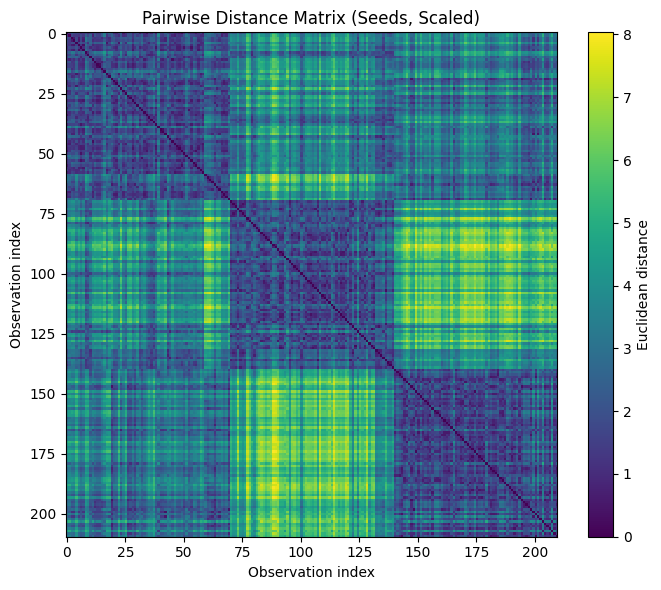

In [ ]:
# If you already created seed_scaled as a DataFrame, use it.
# Otherwise, this will still work if seed_scaled is a NumPy array.
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled

# Compute pairwise distances (Euclidean by default, like get_dist())
dist_mat = pairwise_distances(X, metric="euclidean")

# Visualize the distance matrix (heatmap)
plt.figure(figsize=(7, 6))
plt.imshow(dist_mat, aspect="auto", interpolation="nearest")
plt.colorbar(label="Euclidean distance")
plt.title("Pairwise Distance Matrix (Seeds, Scaled)")
plt.xlabel("Observation index")
plt.ylabel("Observation index")
plt.tight_layout()
plt.show()

From the distance plot above, we can see that some observations are very close to each other. For example, the points clustered in the bottom-left area of the matrix may be highly similar and could potentially belong to the same cluster.

To perform clustering in **Python**, we can use the `KMeans` class from **scikit-learn**. This method partitions the data into a specified number of clusters, **k**, which is set using the `n_clusters` parameter. The algorithm starts by selecting **k** initial cluster centers (randomly by default) and then iteratively updates the assignments and centers until convergence.

Because the initialization is random, the results may vary across runs. To improve stability, `KMeans` can run the algorithm multiple times with different initializations using the `n_init` parameter, and it keeps the best solution based on the lowest **inertia** (within-cluster sum of squares).

For illustration, we can start with **k = 2**, but it is common to try other values (e.g., **k = 3**, **k = 4**) to determine which number of clusters best represents the data.


In [ ]:
# ============================================================
# K-Means Cluster Analysis (Python / Google Colab)
# R equivalent:
#   fit <- kmeans(seed, centers = 2, nstart = 25)
#   table(fit$cluster)
#   fit
# ============================================================

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

RANDOM_STATE = 42

# Use scaled features (recommended for k-means)
# If you prefer the raw seed DataFrame (like R code), replace seed_scaled with seed.
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled

k = 2
kmeans = KMeans(
    n_clusters=k,
    n_init=25,           # analogous to nstart=25
    random_state=RANDOM_STATE
)

kmeans.fit(X)

# Cluster assignments (labels are 0..k-1 in sklearn; add 1 to match R's 1..k)
clusters = kmeans.labels_ + 1

# Display number of observations in each cluster (like table(fit$cluster))
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("Cluster counts:")
print(cluster_counts)

# Show key components analogous to the R kmeans object
print("\nKMeans summary:")
print(f"n_clusters: {kmeans.n_clusters}")
print(f"inertia (within-cluster SSE): {kmeans.inertia_:.5f}")
print(f"n_iter: {kmeans.n_iter_}")

# Cluster centers (in scaled space)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=seed.columns)
centers.index = [f"Cluster {i}" for i in range(1, k + 1)]
centers


Cluster counts:
1     77
2    133
Name: count, dtype: int64

KMeans summary:
n_clusters: 2
inertia (within-cluster SSE): 659.17175
n_iter: 5


,area,perimeter,compactness,length,width,asymmetry,groovelength
Cluster 1,1.140654,1.147887,0.543769,1.128704,1.066613,-0.146525,1.149620
Cluster 2,-0.660378,-0.664566,-0.314814,-0.653460,-0.617513,0.084830,-0.665569


## 3.1 Visualization of k-means Clusters



In [ ]:
# ============================================================
# Visualize k-means clusters (fviz_cluster analogue) using PCA
# R equivalent:
#   fviz_cluster(fit, data=seed)
#   k3 <- kmeans(..., centers=3); k4; k5
#   grid.arrange(p1, p2, p3, p4, nrow=2)
#
# Python approach:
# - Run PCA to 2 components for visualization
# - Plot points in PC1–PC2 space colored by cluster labels
# - Compare k = 2, 3, 4, 5 in a 2x2 grid
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

RANDOM_STATE = 123

# Use scaled data for clustering/visualization (recommended)
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled

# PCA to 2D for visualization (like fviz_cluster)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_.round(4))


Explained variance ratio (PC1, PC2): [0.7187 0.1711]


In [ ]:
def fit_kmeans_and_plot_with_labels(ax, k, X, X_pca, pca_obj, random_state=123, n_init=25, max_labels=210):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = km.fit_predict(X)  # 0..k-1

    # Scatter points colored by cluster assignment
    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=18, alpha=0.9, c=labels)

    # Add point labels (0..n-1)
    n = X_pca.shape[0]
    n_to_label = min(n, max_labels)
    for i in range(n_to_label):
        ax.text(X_pca[i, 0], X_pca[i, 1], str(i), fontsize=7, ha="center", va="center")

    # Centroids in PCA space
    centers_pca = pca_obj.transform(km.cluster_centers_)
    ax.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="X", s=180, edgecolors="k")

    # Label centroids
    for j in range(k):
        ax.text(
            centers_pca[j, 0], centers_pca[j, 1],
            f"Centroid {j}",
            fontsize=10, fontweight="bold",
            ha="left", va="bottom"
        )

    ax.set_title(f"k = {k}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    return km

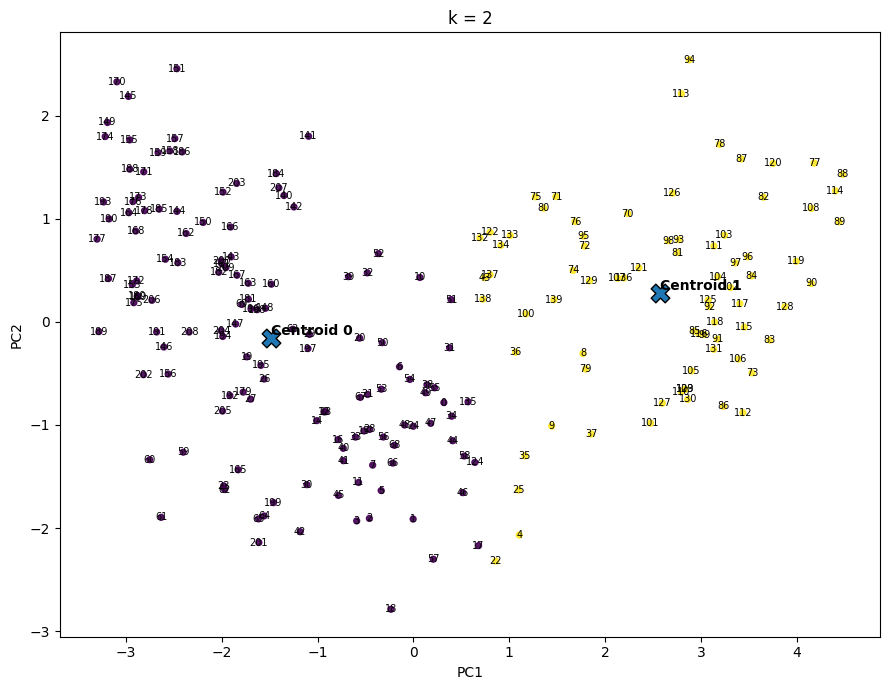

In [ ]:
# Example: k = 2 with labels + centroids
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
kmeans_k2 = fit_kmeans_and_plot_with_labels(ax, k=2, X=X, X_pca=X_pca, pca_obj=pca,
                                           random_state=RANDOM_STATE, n_init=25, max_labels=210)
plt.tight_layout()
plt.show()

In [ ]:
def fit_kmeans_and_plot(ax, k, X, X_pca, random_state=123, n_init=25):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    labels = km.fit_predict(X)  # 0..k-1

    ax.scatter(X_pca[:, 0], X_pca[:, 1], s=18, alpha=0.9, c=labels)
    ax.set_title(f"k = {k}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    # Plot cluster centers in PCA space
    centers_pca = pca.transform(km.cluster_centers_)
    ax.scatter(centers_pca[:, 0], centers_pca[:, 1], marker="X", s=140, edgecolors="k")

    return km


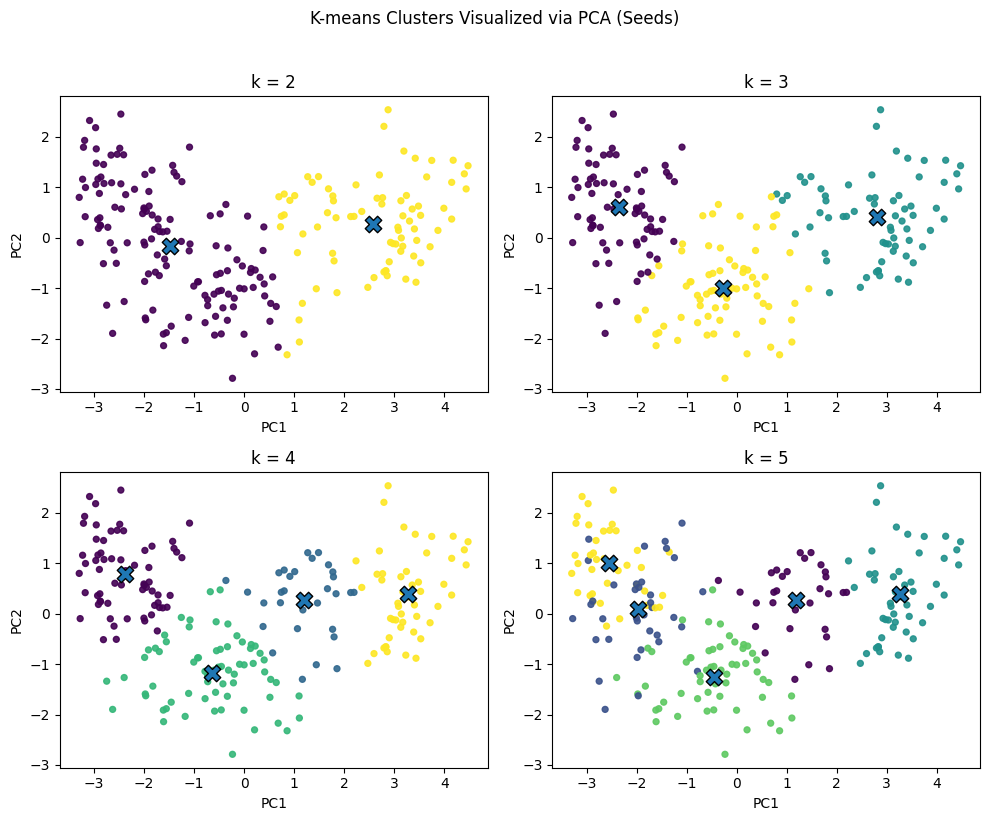

In [ ]:
# ------------------------------------------------------------
# Compare k = 2, 3, 4, 5 in a 2x2 grid (like grid.arrange)
# ------------------------------------------------------------
ks = [2, 3, 4, 5]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

kmeans_models = {}
for ax, k in zip(axes, ks):
    kmeans_models[k] = fit_kmeans_and_plot(ax, k, X, X_pca, random_state=RANDOM_STATE, n_init=25)

fig.suptitle("K-means Clusters Visualized via PCA (Seeds)", y=1.02)
plt.tight_layout()
plt.show()


### 3.2 Determine the Number of Clusters

There is no single “best” way to choose the number of clusters, so we often use several diagnostics together:

1. **Within-Cluster Sum of Squares (WCSS) / Elbow Method**  
   Compute the within-cluster sum of squares (also called **inertia** in scikit-learn) for different values of **k**.  
   In the elbow plot, we look for a point where the improvement starts to level off. In many cases, the elbow may suggest **k = 3** or **k = 4**.


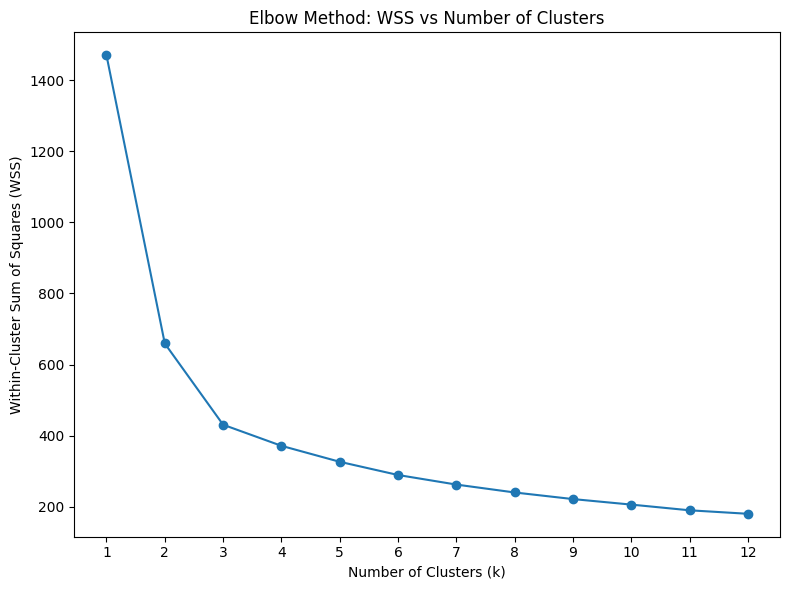

In [ ]:
# ============================================================
# Determine the number of clusters (Elbow Method: WSS vs k)
# R equivalent:
#   wss <- (nrow(seed)-1)*sum(apply(seed,2,var))
#   for (i in 2:12) wss[i] <- sum(kmeans(seed, centers=i)$withinss)
#   plot(1:12, wss, type="b", ...)
#
# Python / sklearn:
# - "Within groups sum of squares" corresponds to KMeans.inertia_
# - Use scaled data (recommended for k-means)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

RANDOM_STATE = 123

# Use scaled data (recommended)
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled

ks = range(1, 13)
wss = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=25, random_state=RANDOM_STATE)
    km.fit(X)
    wss.append(km.inertia_)  # within-cluster sum of squares (WSS)

plt.figure(figsize=(8, 6))
plt.plot(list(ks), wss, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method: WSS vs Number of Clusters")
plt.xticks(list(ks))
plt.tight_layout()
plt.show()


2. **Prediction Strength (Tibshirani and Walther, 2005)**  
   Prediction strength measures how stable the clustering is under data splitting. Tibshirani and Walther (2005) recommend choosing the **largest k** such that prediction strength remains above a threshold (commonly **0.8** or **0.9**).  
   Using this criterion, **k = 2** may be selected (as illustrated in the example below).


In [ ]:
# ============================================================
# prediction.strength() analogue in Python (R: fpc::prediction.strength)
#
# Goal:
# - For each k = Gmin..Gmax:
#   Repeat M times:
#     1) Split data into train/test
#     2) Fit KMeans on train
#     3) "Predict" test labels by nearest train centroids
#     4) Fit KMeans on test (independently)
#     5) Compute prediction strength:
#        For each cluster g in the test clustering, compute the fraction of
#        within-cluster pairs that are also together under predicted labels.
#        Prediction strength for k = min over clusters, then average over repeats.
#
# Return:
# - strength per k
# - suggested k = smallest k with strength >= cutoff (if any)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances_argmin_min

RANDOM_STATE = 123

# Use scaled data (recommended)
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled


def _prediction_strength_once(X, k, random_state=123, test_size=0.5, n_init=25):
    """
    One repetition of prediction strength for a given k.
    """
    X_tr, X_te = train_test_split(X, test_size=test_size, random_state=random_state)

    # Fit KMeans on training
    km_tr = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    km_tr.fit(X_tr)
    centers = km_tr.cluster_centers_

    # Predicted labels for test by nearest training centroids
    pred_te, _ = pairwise_distances_argmin_min(X_te, centers)
    # pred_te in {0,1,...,k-1}

    # Independently cluster the test set
    km_te = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    te_labels = km_te.fit_predict(X_te)

    # Compute prediction strength:
    # For each test cluster g, among all pairs within g (under te_labels),
    # compute fraction that are also together under pred_te.
    strengths = []
    for g in range(k):
        idx = np.where(te_labels == g)[0]
        m = len(idx)
        if m < 2:
            # If cluster has <2 points, it provides no pair information.
            # Following common practice, treat it as strength 0 (conservative).
            strengths.append(0.0)
            continue

        # Count within-cluster pairs that are also predicted together
        labels_pred_g = pred_te[idx]
        # total pairs in this cluster
        total_pairs = m * (m - 1) / 2

        # number of pairs with same predicted label:
        # sum over predicted-label groups within this test cluster: choose(n_j, 2)
        _, counts = np.unique(labels_pred_g, return_counts=True)
        same_pred_pairs = np.sum(counts * (counts - 1) / 2)

        strengths.append(same_pred_pairs / total_pairs)

    # prediction strength for this repetition is min over clusters
    return float(np.min(strengths))


def prediction_strength(X, Gmin=2, Gmax=15, M=10, cutoff=0.8,
                        test_size=0.5, n_init=25, random_state=123):
    """
    Compute prediction strength for k = Gmin..Gmax with M repetitions.
    """
    ks = list(range(Gmin, Gmax + 1))
    ps_means = []

    rng = np.random.RandomState(random_state)
    for k in ks:
        vals = []
        for m in range(M):
            # vary the split seed across repetitions (like R does internally)
            seed_m = int(rng.randint(0, 10**9))
            vals.append(_prediction_strength_once(
                X, k, random_state=seed_m, test_size=test_size, n_init=n_init
            ))
        ps_means.append(np.mean(vals))

    out = pd.DataFrame({"k": ks, "prediction_strength": ps_means})

    eligible = out[out["prediction_strength"] >= cutoff]
    suggested_k = int(eligible["k"].iloc[0]) if len(eligible) else None

    return out, suggested_k


# --- Run the analogue of:
# prediction.strength(seed, Gmin=2, Gmax=15, M=10, cutoff=0.8)
ps_table, k_star = prediction_strength(
    X,
    Gmin=2, Gmax=15, M=10, cutoff=0.8,
    test_size=0.5, n_init=25, random_state=RANDOM_STATE
)

display(ps_table)

if k_star is None:
    print("No k in [2, 15] meets the cutoff of 0.8.")
else:
    print(f"Suggested k (smallest with prediction strength >= 0.8): {k_star}")


,k,prediction_strength
0,2,0.871203
1,3,0.782728
2,4,0.434025
3,5,0.423115
4,6,0.388486
5,7,0.327558
6,8,0.325660
7,9,0.275534
8,10,0.286491
9,11,0.211494


Suggested k (smallest with prediction strength >= 0.8): 2


3. **Other Cluster Validity Measures**  
   Additional indices can help assess cluster quality, such as:
   - **Average Silhouette Coefficient** (ranges from **-1 to 1**; **higher is better**)  
   - **Dunn Index** (ranges from **0 to ∞**; **higher is better**)

In Python, the **silhouette score** is widely used and available in `sklearn.metrics`. Other indices (like the Dunn index) can be computed with additional packages or custom functions.


In [ ]:
# ============================================================
# R -> Python: silhouette width vs number of clusters (k = 2..15)
# R code:
#   d = dist(seed, method="euclidean")
#   for i=2:15:
#     kmeans(seed,i)
#     cluster.stats(d, cluster)$avg.silwidth, $dunn
#   plot(k vs avg.silwidth)
#
# Python equivalents:
# - dist()                     -> pairwise_distances(X, metric="euclidean")
# - avg.silwidth (avg)         -> silhouette_score(X, labels, metric="euclidean")
# - dunn index (not built-in)  -> implement Dunn index from distance matrix
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

RANDOM_STATE = 123

# Use scaled data (recommended for k-means)
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled

# Precompute Euclidean distance matrix (like d = dist(seed))
D = pairwise_distances(X, metric="euclidean")

def dunn_index(D, labels):
    """
    Dunn index = (minimum inter-cluster distance) / (maximum intra-cluster distance)
    - Inter-cluster distance: minimum distance between points in different clusters
    - Intra-cluster diameter: maximum distance between points within the same cluster
    """
    labels = np.asarray(labels)
    clusters = np.unique(labels)

    # Maximum intra-cluster distance (diameter)
    max_intra = 0.0
    for c in clusters:
        idx = np.where(labels == c)[0]
        if len(idx) < 2:
            continue
        diam = np.max(D[np.ix_(idx, idx)])
        if diam > max_intra:
            max_intra = diam

    # Minimum inter-cluster distance
    min_inter = np.inf
    for i, ci in enumerate(clusters):
        idx_i = np.where(labels == ci)[0]
        for cj in clusters[i + 1:]:
            idx_j = np.where(labels == cj)[0]
            dist_ij = np.min(D[np.ix_(idx_i, idx_j)])
            if dist_ij < min_inter:
                min_inter = dist_ij

    if max_intra == 0.0 or not np.isfinite(min_inter):
        return np.nan

    return float(min_inter / max_intra)

# Compute results for k = 2..15
rows = []
for k in range(2, 16):
    km = KMeans(n_clusters=k, n_init=25, random_state=RANDOM_STATE)
    labels = km.fit_predict(X)

    sil = silhouette_score(X, labels, metric="euclidean")
    dunn = dunn_index(D, labels)

    rows.append([k, sil, dunn])

result = pd.DataFrame(rows, columns=["k", "avg_silhouette", "dunn"])
result


,k,avg_silhouette,dunn
0,2,0.465772,0.086952
1,3,0.400727,0.118818
2,4,0.327574,0.071434
3,5,0.283674,0.076568
4,6,0.291278,0.093823
5,7,0.276684,0.104198
6,8,0.260239,0.099849
7,9,0.258406,0.105156
8,10,0.255054,0.119686
9,11,0.266961,0.120200


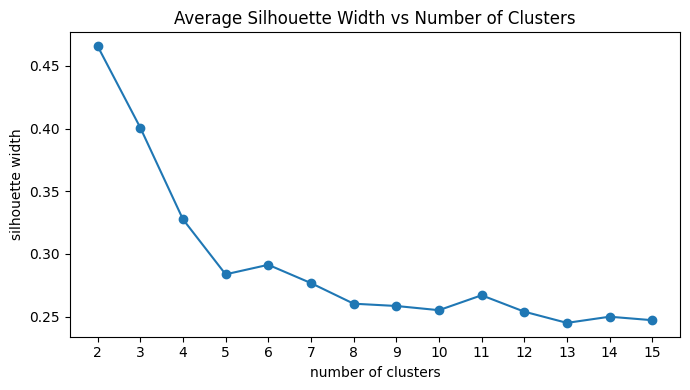

In [ ]:
# Plot silhouette width vs number of clusters
plt.figure(figsize=(7, 4))
plt.plot(result["k"], result["avg_silhouette"], marker="o")
plt.xlabel("number of clusters")
plt.ylabel("silhouette width")
plt.title("Average Silhouette Width vs Number of Clusters")
plt.xticks(result["k"])
plt.tight_layout()
plt.show()


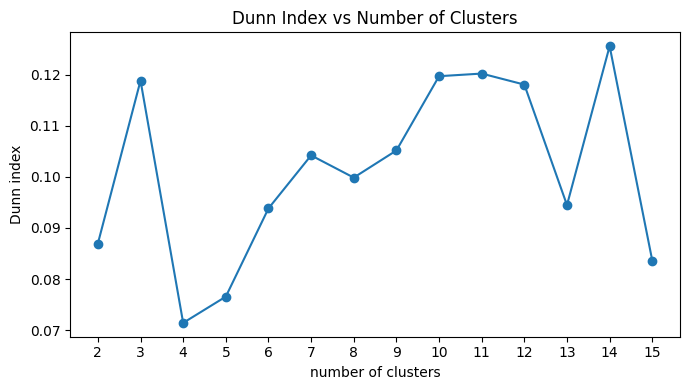

In [ ]:
# Optional: also plot Dunn index vs number of clusters
plt.figure(figsize=(7, 4))
plt.plot(result["k"], result["dunn"], marker="o")
plt.xlabel("number of clusters")
plt.ylabel("Dunn index")
plt.title("Dunn Index vs Number of Clusters")
plt.xticks(result["k"])
plt.tight_layout()
plt.show()


# 4 Hierarchical clustering

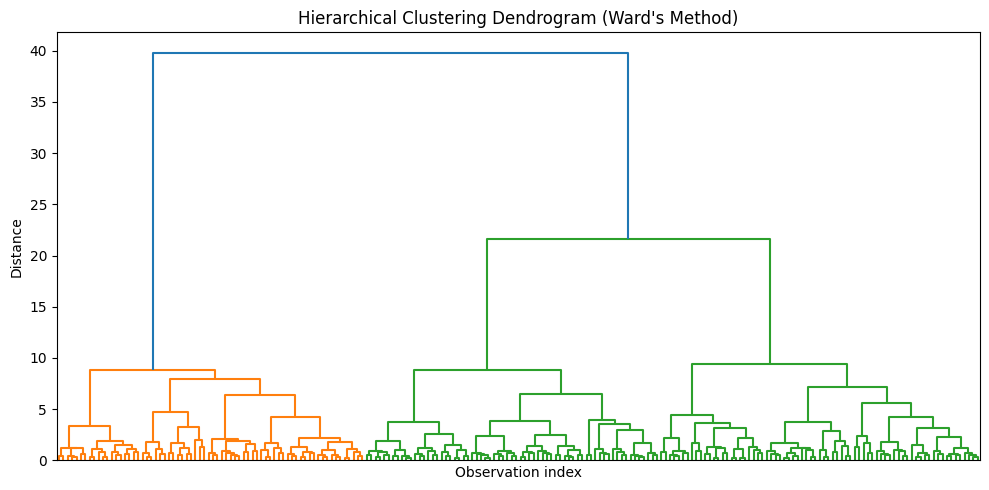

,count
1,70
2,67
3,73


In [ ]:
# ============================================================
# Ward's Method (Hierarchical Clustering) — Python / Google Colab
# R equivalent:
#   seed.dist = dist(seed)
#   seed.hclust = hclust(seed.dist, method="ward")
#   plot(seed.hclust)
#   seed.3clust = cutree(seed.hclust, k=3)
#   seed[seed.3clust==3,]
#   plotcluster(seed, seed.3clust)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA

RANDOM_STATE = 123

# Use scaled data for clustering (recommended)
# If you want to match R's raw-data behavior exactly, replace seed_scaled with seed.
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled

# ------------------------------------------------------------
# 1) Distance matrix (Euclidean) + Ward linkage
# ------------------------------------------------------------
# pdist computes condensed distance matrix (like dist(seed) in R)
d_condensed = pdist(X, metric="euclidean")

# Ward hierarchical clustering
Z = linkage(X, method="ward")  # Ward uses Euclidean distances internally

# ------------------------------------------------------------
# 2) Plot dendrogram
# ------------------------------------------------------------
plt.figure(figsize=(10, 5))
dendrogram(Z, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram (Ward's Method)")
plt.xlabel("Observation index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3) Cut dendrogram at k = 3 clusters
# ------------------------------------------------------------
seed_3clust = fcluster(Z, t=3, criterion="maxclust")  # labels: 1..k
pd.Series(seed_3clust).value_counts().sort_index()


In [ ]:
# ------------------------------------------------------------
# 4) See which observations are in cluster 3 (like seed[seed.3clust==3,])
# ------------------------------------------------------------
seed_cluster3 = seed.loc[seed_3clust == 3, :]  # uses your original seed DataFrame
seed_cluster3.head()


,area,perimeter,compactness,length,width,asymmetry,groovelength
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


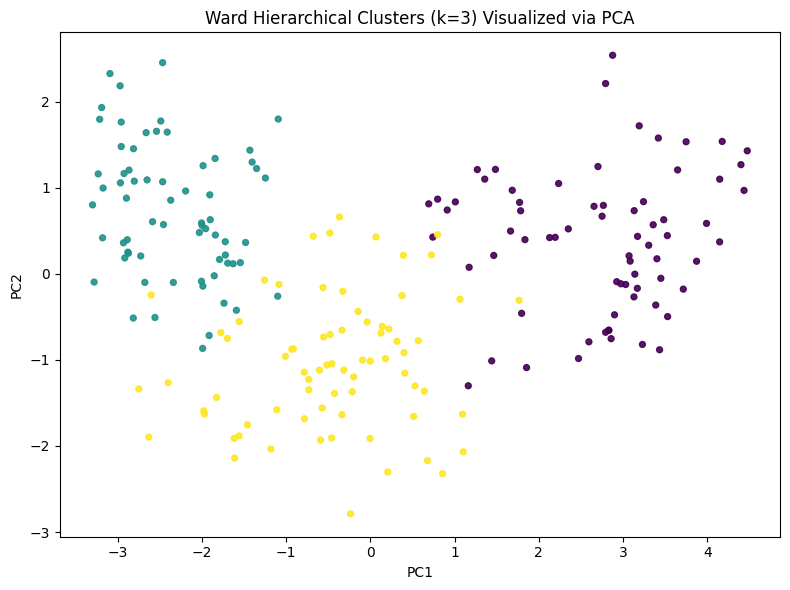

In [ ]:
# ------------------------------------------------------------
# 5) "plotcluster" style visualization (PCA to 2D)
# ------------------------------------------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=seed_3clust, s=18, alpha=0.9)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Ward Hierarchical Clusters (k=3) Visualized via PCA")
plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------------------------------------
# (Optional) Cluster means on the RAW (unscaled) data, like "cluster centroids"
# ------------------------------------------------------------
seed_with_cluster = seed.copy()
seed_with_cluster["cluster"] = seed_3clust

cluster_means_raw = seed_with_cluster.groupby("cluster").mean(numeric_only=True)
cluster_means_raw


,area,perimeter,compactness,length,width,asymmetry,groovelength
cluster,,,,,,,
1,18.371429,16.145429,0.884400,6.158171,3.684629,3.639157,6.017371
2,11.872388,13.257015,0.848072,5.238940,2.848537,4.949433,5.122209
3,14.199041,14.233562,0.879190,5.478233,3.226452,2.612181,5.086178


## 5. (Optional) Model-Based Cluster Analysis

A newer clustering approach, **model-based clustering**, treats clustering as a **maximum likelihood** problem under a **Gaussian (Normal) mixture model**.

In this framework, generating an observation can be viewed as:
1. Randomly selecting a cluster (i.e., a component of the mixture) with its own centroid (mean of a multivariate Normal distribution), and  
2. Adding noise according to that component’s variance (and covariance).

When the noise is Gaussian and the covariance structure is simple, the resulting clusters can look **roughly spherical**, similar to k-means. More generally, model-based clustering can be seen as a **probabilistic generalization of k-means**.

The model is fit using the **Expectation–Maximization (EM)** algorithm, an iterative procedure that maximizes the likelihood when the model contains **latent (unobserved)** variables such as cluster membership.

A major advantage of model-based clustering is that the question **“How many clusters?”** becomes a **model selection** problem (e.g., selecting the best mixture model using criteria like AIC or BIC).

For more details on the method and practical implementations, see the references **(1)** and **(2)**.


In [ ]:
# ============================================================
# (Optional) Model-Based Cluster Analysis (R: mclust::Mclust)
#
# R equivalent:
#   library(mclust)
#   mclust_result = Mclust(seed)
#   summary(mclust_result)
#   plot(mclust_result)
#
# Python analogue:
# - Use Gaussian Mixture Models (GMM) via sklearn.mixture.GaussianMixture
# - Select number of components by minimizing BIC (standard definition)
# - Provide a summary + plots (BIC curve + PCA cluster plot)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

RANDOM_STATE = 123

# Use scaled data (recommended for mixture models too)
X = seed_scaled.values if hasattr(seed_scaled, "values") else seed_scaled
n, p = X.shape
print("n =", n, "| p =", p)


n = 210 | p = 7


In [ ]:
# ------------------------------------------------------------
# 1) Fit GMMs across a range of components and pick best by BIC
# ------------------------------------------------------------
components_range = range(1, 11)

bic_scores = []
aic_scores = []
models = []

for k in components_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",   # closest general analogue to mclust's flexible covariance families
        random_state=RANDOM_STATE,
        n_init=10
    )
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))   # lower is better (standard BIC)
    aic_scores.append(gmm.aic(X))   # lower is better
    models.append(gmm)

best_idx = int(np.argmin(bic_scores))
best_k = list(components_range)[best_idx]
best_gmm = models[best_idx]

print(f"Best model by BIC: k = {best_k}")
print(f"BIC (min): {bic_scores[best_idx]:.3f}")
print(f"AIC:       {aic_scores[best_idx]:.3f}")


Best model by BIC: k = 4
BIC (min): -104.029
AIC:       -582.665


In [ ]:
# ------------------------------------------------------------
# 2) "Summary" analogue: log-likelihood, BIC/AIC, cluster sizes
# ------------------------------------------------------------
labels = best_gmm.predict(X)              # 0..k-1
proba = best_gmm.predict_proba(X)         # responsibilities
uncertainty = 1 - np.max(proba, axis=1)   # simple uncertainty proxy

cluster_sizes = pd.Series(labels).value_counts().sort_index()
cluster_sizes.index = [f"Cluster {i+1}" for i in cluster_sizes.index]  # 1-based display

summary_df = pd.DataFrame({
    "k": [best_k],
    "log_likelihood": [best_gmm.score(X) * n],  # total log-likelihood
    "n_params": [best_gmm._n_parameters()],
    "BIC": [best_gmm.bic(X)],
    "AIC": [best_gmm.aic(X)],
    "mean_uncertainty": [uncertainty.mean()]
})

display(summary_df)
print("\nClustering table (counts):")
display(cluster_sizes.to_frame("count"))


,k,log_likelihood,n_params,BIC,AIC,mean_uncertainty
0,4,434.332472,143,-104.028567,-582.664944,0.01024



Clustering table (counts):


,count
Cluster 1,44
Cluster 2,73
Cluster 3,46
Cluster 4,47


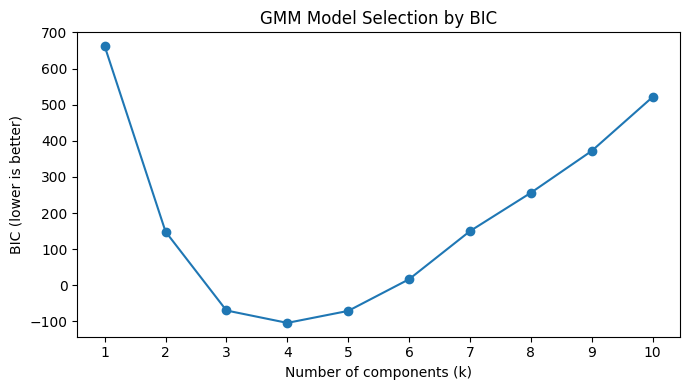

In [ ]:
# ------------------------------------------------------------
# 3) Plot BIC curve (like mclust BIC plot)
# Note: sklearn's BIC uses the standard sign; lower is better.
# In mclust output, they often plot BIC with a different sign convention.
# ------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(list(components_range), bic_scores, marker="o")
plt.xlabel("Number of components (k)")
plt.ylabel("BIC (lower is better)")
plt.title("GMM Model Selection by BIC")
plt.xticks(list(components_range))
plt.tight_layout()
plt.show()


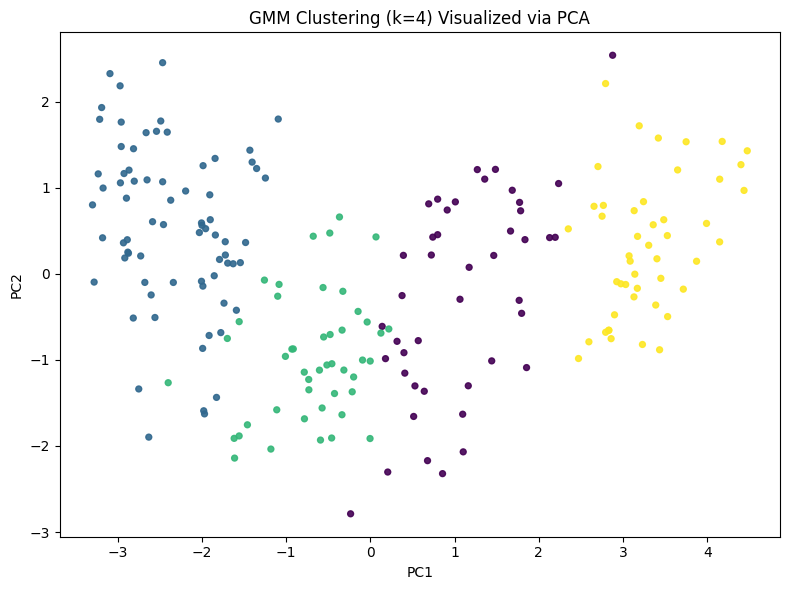

In [ ]:
# ------------------------------------------------------------
# 4) Plot clustering result in 2D using PCA (like mclust classification plot)
# ------------------------------------------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=18, alpha=0.9)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"GMM Clustering (k={best_k}) Visualized via PCA")
plt.tight_layout()
plt.show()


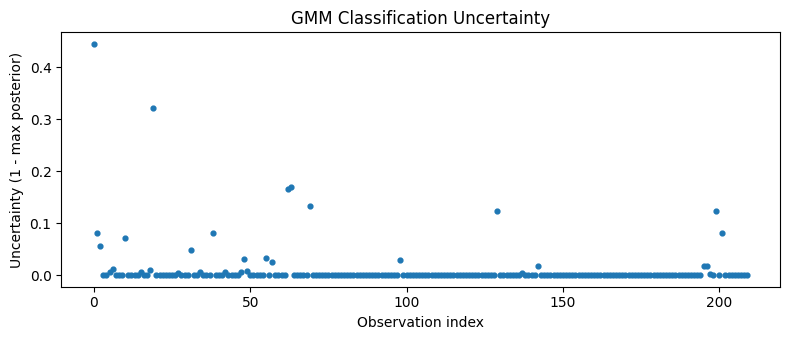

In [ ]:
# ------------------------------------------------------------
# 5) Optional: Uncertainty plot (like mclust uncertainty plot)
# ------------------------------------------------------------
plt.figure(figsize=(8, 3.5))
plt.scatter(np.arange(n), uncertainty, s=12)
plt.xlabel("Observation index")
plt.ylabel("Uncertainty (1 - max posterior)")
plt.title("GMM Classification Uncertainty")
plt.tight_layout()
plt.show()


In [ ]:
%%shell
jupyter nbconvert --to html ///content/10_Clustering.ipynb

[NbConvertApp] Converting notebook ///content/10_Clustering.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 11 image(s).
[NbConvertApp] Writing 1430288 bytes to /content/10_Clustering.html
